In [159]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import warnings
import seaborn as sns

from scipy.stats import zscore
from scipy.stats.mstats import winsorize

import math
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

warnings.filterwarnings('ignore')
# Display up to 500 columns of a wide dataframe, instead of ...-ing them 
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# Functions

In [160]:
# Pass in a dataframe, a list of columns to interpolate, and the limit direction.
# Loop through all of the columns and interpolate.
# Return the updated dataframe.
def interpolate_missing(df,key_column,column_list,limit_dir,**kwargs):
    interp_how = kwargs.get('interp_how','linear')
    for each_value in df[key_column].unique():
        for column in column_list:
            mask = (df[key_column] == each_value)
            df.loc[mask, column] = df.loc[mask, column].interpolate(limit_direction=limit_dir,method=interp_how)
    return df

# Assignment
In this assignment, you'll continue working with the U.S. Education Dataset from Kaggle. The data gives detailed state level information on the several facets of the state of education on annual basis. To learn more about the data and the column descriptions, you can view the Kaggle link above. You should access the data from the Thinkful database. 

Don't forget to apply the most suitable missing value filling techniques you applied in the previous checkpoints to the data. You should provide your answers to the following questions after you handled the missing values.

In [161]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

# I connected via pgAdmin4 and verified the table name is the same as the db name
used_df = pd.read_sql_query('select * from useducation',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

In [162]:
# There are a lot of entries from US territories that are mostly NaNs and
# which don't have the full complement of data the states have--
# the only populated columns in most of these rows are for GRADES_*.
# These rows aren't particularly useful otherwise, so let's just drop them.
state_counts = used_df['STATE'].value_counts()

# A full complement of data for a state is 26 rows/years.
to_remove = state_counts[state_counts < 26].index

# Keep rows in the df where the state is not on the list to_remove
used_df = used_df[~used_df['STATE'].isin(to_remove)]

In [163]:
used_df = interpolate_missing(used_df,
                                     'STATE',
                                     ['ENROLL',
                                      'OTHER_EXPENDITURE',
                                      'GRADES_PK_G',
                                      'GRADES_KG_G',
                                      'GRADES_4_G',
                                      'GRADES_8_G',
                                      'GRADES_12_G',
                                      'GRADES_1_8_G',
                                      'GRADES_9_12_G',
                                      'GRADES_ALL_G'
                                     ],                                     
                                     'both')

In [164]:
for this_state in used_df['STATE'].unique():
    print("Interpolating scores for {}".format(this_state))
    used_df = interpolate_missing(used_df,
                                         'STATE',
                                         ['AVG_MATH_4_SCORE',
                                          'AVG_MATH_8_SCORE',
                                          'AVG_READING_4_SCORE',
                                          'AVG_READING_8_SCORE'
                                         ],
                                         'both',interp_how='linear')

Interpolating scores for ALABAMA
Interpolating scores for ALASKA
Interpolating scores for ARIZONA
Interpolating scores for ARKANSAS
Interpolating scores for CALIFORNIA
Interpolating scores for COLORADO
Interpolating scores for CONNECTICUT
Interpolating scores for DELAWARE
Interpolating scores for DISTRICT_OF_COLUMBIA
Interpolating scores for FLORIDA
Interpolating scores for GEORGIA
Interpolating scores for HAWAII
Interpolating scores for IDAHO
Interpolating scores for ILLINOIS
Interpolating scores for INDIANA
Interpolating scores for IOWA
Interpolating scores for KANSAS
Interpolating scores for KENTUCKY
Interpolating scores for LOUISIANA
Interpolating scores for MAINE
Interpolating scores for MARYLAND
Interpolating scores for MASSACHUSETTS
Interpolating scores for MICHIGAN
Interpolating scores for MINNESOTA
Interpolating scores for MISSISSIPPI
Interpolating scores for MISSOURI
Interpolating scores for MONTANA
Interpolating scores for NEBRASKA
Interpolating scores for NEVADA
Interpolati

In [165]:
# Except for AVG scores, rows with a year == 2017 have all NaNs in other columns.
# We've interpolated the AVG columns and so have made use of the 2017 rows
# where those columns are populated, so let's drop 2017 now.
used_df = used_df[used_df['YEAR'] != 2017]

Validating that all of the NaNs have been dealt with:

In [166]:
# The sum of null rows for each column * 100, divided by the total number of rows for each column:
used_df.isnull().sum()*100/used_df.isnull().count()

PRIMARY_KEY                     0.0
STATE                           0.0
YEAR                            0.0
ENROLL                          0.0
TOTAL_REVENUE                   0.0
FEDERAL_REVENUE                 0.0
STATE_REVENUE                   0.0
LOCAL_REVENUE                   0.0
TOTAL_EXPENDITURE               0.0
INSTRUCTION_EXPENDITURE         0.0
SUPPORT_SERVICES_EXPENDITURE    0.0
OTHER_EXPENDITURE               0.0
CAPITAL_OUTLAY_EXPENDITURE      0.0
GRADES_PK_G                     0.0
GRADES_KG_G                     0.0
GRADES_4_G                      0.0
GRADES_8_G                      0.0
GRADES_12_G                     0.0
GRADES_1_8_G                    0.0
GRADES_9_12_G                   0.0
GRADES_ALL_G                    0.0
AVG_MATH_4_SCORE                0.0
AVG_MATH_8_SCORE                0.0
AVG_READING_4_SCORE             0.0
AVG_READING_8_SCORE             0.0
dtype: float64

## Say, we want to understand the relationship between the expenditures of the governments and the students' overall success in the math and reading.

## 1. Create a new score variable from the weighted averages of all score variables in the datasets. Notice that the number of students in the 4th grade isn't the same as the number of students in the 8th grade. So, you should appropriately weigh the scores!

This actually sounds like a weighted score! 

The weight for 4th graders should be:
    `GRADES_4_G  / (GRADES_4_G + GRADES_8_G)`

The weight for 8th graders should be:
    `GRADES_8_G  / (GRADES_4_G + GRADES_8_G)`

In [167]:
# Calculate weights for 4th grade and 8th grade
used_df['4G_W'] = used_df['GRADES_4_G'] / (used_df['GRADES_4_G'] + used_df['GRADES_8_G'])
used_df['8G_W'] = used_df['GRADES_8_G'] / (used_df['GRADES_4_G'] + used_df['GRADES_8_G'])

# Calculate weighted averages for 4th graders and 8th graders
used_df['WEIGHTED_AVG_SCORE4'] = ((used_df['AVG_MATH_4_SCORE'] + used_df['AVG_READING_4_SCORE']) * used_df['4G_W']) / 2
used_df['WEIGHTED_AVG_SCORE8'] = ((used_df['AVG_MATH_8_SCORE'] + used_df['AVG_READING_8_SCORE']) * used_df['8G_W']) / 2

# Add weighted averages together to get overall weighted average
used_df['WEIGHTED_AVG_SCORE'] = used_df['WEIGHTED_AVG_SCORE4'] + used_df['WEIGHTED_AVG_SCORE8']

In [168]:
used_df[['4G_W','8G_W','WEIGHTED_AVG_SCORE4','WEIGHTED_AVG_SCORE8','WEIGHTED_AVG_SCORE']]

,4G_W,8G_W,WEIGHTED_AVG_SCORE4,WEIGHTED_AVG_SCORE8,WEIGHTED_AVG_SCORE
0,0.499668,0.500332,104.003749,128.201053,232.204803
1,0.525867,0.474133,114.476187,127.186788,241.662975
2,0.530388,0.469612,111.770484,123.868586,235.639070
3,0.490240,0.509760,102.666108,132.775175,235.441283
4,0.535257,0.464743,108.433295,123.177701,231.610996
5,0.529387,0.470613,115.010373,126.787525,241.797898
6,0.530432,0.469568,119.139399,126.420078,245.559478
7,0.507983,0.492017,107.765869,129.018221,236.784089
8,0.538405,0.461595,99.916655,115.606856,215.523511
9,0.535927,0.464073,112.162133,121.129488,233.291621


In [169]:
# Looks good! We can drop the unneeded variables
used_df.drop(['4G_W','8G_W','WEIGHTED_AVG_SCORE4','WEIGHTED_AVG_SCORE8'],axis='columns',inplace=True)

In [170]:
used_df.describe()

,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE,GRADES_PK_G,GRADES_KG_G,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE,WEIGHTED_AVG_SCORE
count,1280.000000,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1.280000e+03,1.280000e+03,1.280000e+03,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000
mean,2004.017969,9.116706e+05,9.092082e+06,7.663723e+05,4.216553e+06,4.109157e+06,9.196681e+06,4.762966e+06,2.680331e+06,4.222320e+05,9.027693e+05,19038.937500,69664.090234,70485.978906,70194.607422,59614.644141,5.668963e+05,2.706240e+05,8.565999e+05,232.363697,277.075636,218.320324,262.958175,247.661491
std,7.205711,1.060012e+06,1.174519e+07,1.145242e+06,5.543072e+06,5.482971e+06,1.197813e+07,6.293004e+06,3.353349e+06,5.278970e+05,1.327562e+06,30686.330588,82275.301785,82249.043359,80702.085178,69833.118559,6.585042e+05,3.152977e+05,9.968944e+05,10.587956,10.263288,7.834835,6.073342,7.518495
min,1992.000000,4.386600e+04,4.656500e+05,3.102000e+04,0.000000e+00,2.209300e+04,4.816650e+05,2.655490e+05,1.399630e+05,1.154100e+04,1.270800e+04,0.000000,3459.000000,2548.000000,1485.000000,484.000000,1.922600e+04,2.758000e+03,2.455400e+04,187.134670,232.831510,178.557612,236.379102,210.794614
25%,1998.000000,2.533458e+05,2.186305e+06,1.893540e+05,1.153097e+06,7.158345e+05,2.165404e+06,1.168032e+06,6.357900e+05,9.902825e+04,1.815645e+05,2594.500000,19891.000000,19686.750000,20119.500000,17059.750000,1.590518e+05,7.626500e+04,2.357432e+05,225.509728,271.173255,214.193624,259.159480,243.700154
50%,2004.000000,6.472755e+05,5.079546e+06,4.033765e+05,2.537074e+06,2.055780e+06,5.234506e+06,2.657452e+06,1.525406e+06,2.658320e+05,5.102595e+05,9403.500000,48757.000000,49305.500000,49427.500000,39663.500000,4.001715e+05,1.817525e+05,6.050375e+05,233.551337,278.829503,220.028740,264.072770,248.734904
75%,2010.000000,1.006750e+06,1.085985e+07,8.289660e+05,5.080939e+06,4.768680e+06,1.074519e+07,5.568028e+06,3.229651e+06,5.102788e+05,9.668515e+05,24263.500000,79396.000000,79093.250000,80452.250000,70630.000000,6.385595e+05,3.127090e+05,9.669560e+05,240.621706,283.982830,223.659162,267.294955,252.938868
max,2016.000000,6.307022e+06,8.921726e+07,9.990221e+06,5.090457e+07,3.610526e+07,8.532013e+07,4.396452e+07,2.605802e+07,3.995951e+06,1.022366e+07,250911.000000,530531.000000,493415.000000,500143.000000,498403.000000,3.929869e+06,2.013687e+06,5.944746e+06,253.420961,300.568235,236.773867,277.191363,264.696429


## 2. What are the correlations between this newly created score variable and the expenditure types? Which 1 of the expenditure types is more correlated than the others?

In [171]:
used_df_exp_vs_score = used_df[['INSTRUCTION_EXPENDITURE',
                                'SUPPORT_SERVICES_EXPENDITURE',
                                'OTHER_EXPENDITURE',
                                'CAPITAL_OUTLAY_EXPENDITURE',
                                'WEIGHTED_AVG_SCORE']]
used_df_exp_vs_score.corr()

,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE,WEIGHTED_AVG_SCORE
INSTRUCTION_EXPENDITURE,1.000000,0.976889,0.909554,0.896103,0.126542
SUPPORT_SERVICES_EXPENDITURE,0.976889,1.000000,0.952989,0.917782,0.126803
OTHER_EXPENDITURE,0.909554,0.952989,1.000000,0.921464,0.052478
CAPITAL_OUTLAY_EXPENDITURE,0.896103,0.917782,0.921464,1.000000,0.055601
WEIGHTED_AVG_SCORE,0.126542,0.126803,0.052478,0.055601,1.000000


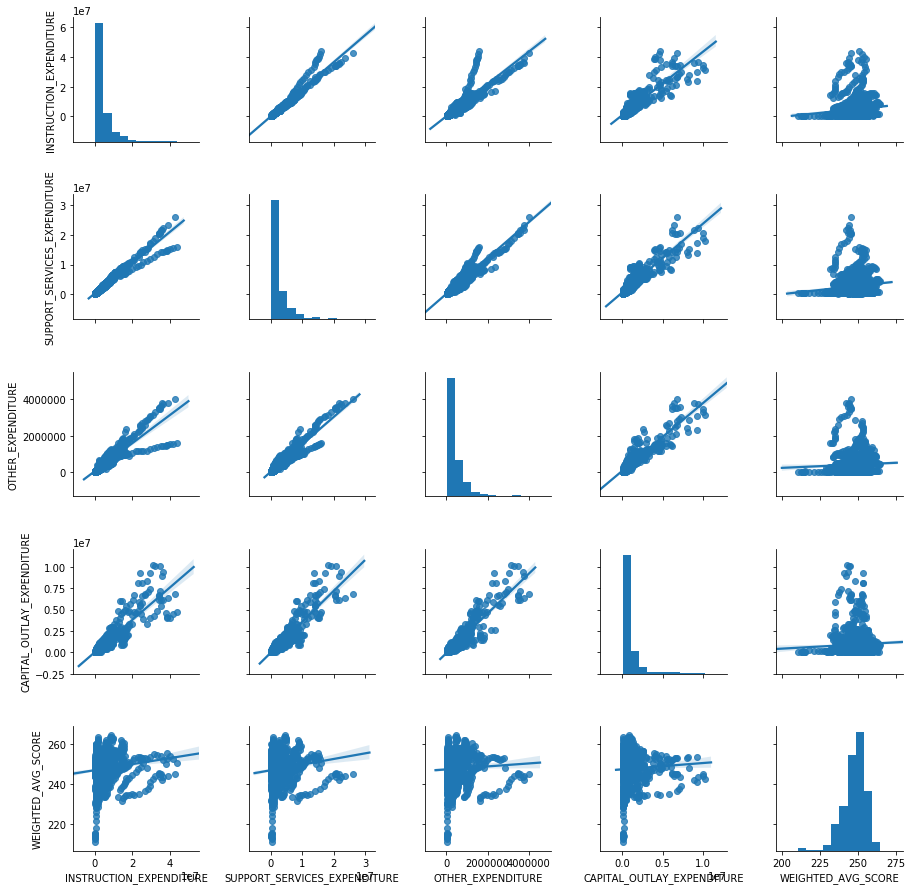

In [172]:
sns.pairplot(used_df_exp_vs_score,kind='reg')

__None of these are a really great fit, but the two highest correlated values for WEIGHTED_AVG_SCORE are associated with SUPPORT_SERVICES_EXPENDITURE and INSTRUCTION_EXPENDITURE.__

## 3. Now, apply PCA to the 4 expenditure types. How much of the total variance is explained by the 1st component?

I'm going to walk through the "by hand" steps of the checkpoint and see if I can make better sense of this.

First, create a covariance matrix--this is how we determine how closely the variances of these variables match.

In [173]:
used_df_exp = used_df[['INSTRUCTION_EXPENDITURE',
                        'SUPPORT_SERVICES_EXPENDITURE',
                        'OTHER_EXPENDITURE',
                        'CAPITAL_OUTLAY_EXPENDITURE']]

In [174]:
# Normalize the data so that all variables have a mean of 0 and standard deviation
# of 1.
X = StandardScaler().fit_transform(used_df_exp)

# The NumPy covariance function assumes that variables are represented by rows,
# not columns, so we transpose X.
Xt = X.T
Cx = np.cov(Xt)
print('Covariance Matrix:\n', Cx)

Covariance Matrix:
 [[1.00078186 0.97765258 0.91026466 0.89680376]
 [0.97765258 1.00078186 0.95373397 0.91849912]
 [0.91026466 0.95373397 1.00078186 0.9221848 ]
 [0.89680376 0.91849912 0.9221848  1.00078186]]


Next up: calculate eigenvectors and eigenvalues, which we can use to better understand how to transform the covariance matrix 

In [175]:
# Calculating eigenvalues and eigenvectors.
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

# Inspecting the eigenvalues and eigenvectors.
for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:, i].T
    print('Eigenvector {}: \n{}'.format(i + 1, eigvec_cov))
    print('Eigenvalue {}: {}'.format(i + 1, eig_val_cov[i]))
    print(40 * '-')

print(
    'The percentage of total variance in the dataset explained by each',
    'component calculated by hand.\n',
    eig_val_cov / sum(eig_val_cov)
)

Eigenvector 1: 
[-0.49943052 -0.50803207 -0.49952747 -0.49289439]
Eigenvalue 1: 3.790780770753682
----------------------------------------
Eigenvector 2: 
[-0.53418934  0.79173316 -0.29529702  0.0244953 ]
Eigenvalue 2: 0.01384900753103163
----------------------------------------
Eigenvector 3: 
[-0.59012268 -0.33063993  0.23882593  0.69670269]
Eigenvalue 3: 0.12138943153250108
----------------------------------------
Eigenvector 4: 
[ 0.34200312 -0.07575786 -0.7786104   0.52063468]
Eigenvalue 4: 0.07710823349787789
----------------------------------------
The percentage of total variance in the dataset explained by each component calculated by hand.
 [0.94695481 0.00345955 0.03032365 0.019262  ]


__The highest-correlated component can explain about 94.7% of the overall data's variance.__

Continuing through the rest of the steps from the checkpoint--this scree plot can help us decide how many variables to keep.

I think this is confirming we can reduce to one variable, because only one of them has a value > 1...?

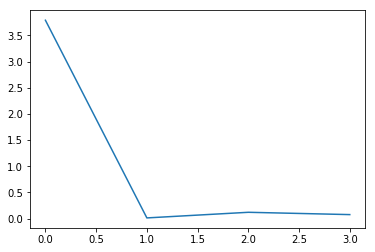

[3.79078077 0.01384901 0.12138943 0.07710823]


In [176]:
# print scree plot
plt.plot(eig_val_cov)
plt.show()

print(eig_val_cov)

Comparing the values I calculated myself with the output from the sklearn PCA function fit_transform(?).

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.94695481 0.03032365 0.019262   0.00345955]


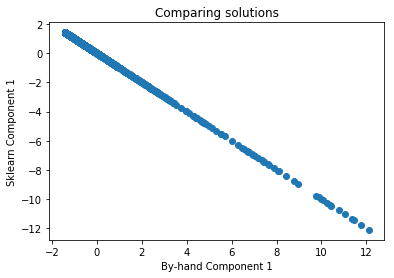

In [177]:
sklearn_pca = PCA(n_components=4)
Y_sklearn = sklearn_pca.fit_transform(X)

P = eig_vec_cov[:, 0]

# Transform X into Y.
Y = P.T.dot(Xt)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

# Compare the sklearn solution to ours – a perfect match.
plt.plot(Y_sklearn[:, 0], Y, 'o')
plt.title('Comparing solutions')
plt.ylabel('Sklearn Component 1')
plt.xlabel('By-hand Component 1')
plt.show()

## 4. What is the correlation between the overall score variable and the 1st principal component?

In [183]:
used_df['PRINCIPAL_COMPONENT'] = Y
used_df[['PRINCIPAL_COMPONENT','WEIGHTED_AVG_SCORE']].corr()

,PRINCIPAL_COMPONENT,WEIGHTED_AVG_SCORE
PRINCIPAL_COMPONENT,1.000000,-0.093123
WEIGHTED_AVG_SCORE,-0.093123,1.000000


__Low--only -9.31%.__

A plot of the two columns confirms there's not much of a relationship.

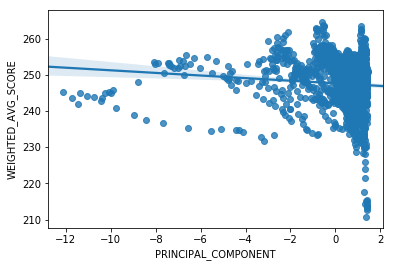

In [189]:
sns.regplot(data=used_df,
            y='WEIGHTED_AVG_SCORE',
            x='PRINCIPAL_COMPONENT')

## 5. If you were to choose the best variables for your model, would you prefer using the 1st principal component instead of the expenditure variables? Why?

_Pros:_
Reducing the number of variables helps mitigate the curse of multidimensionality--fewer numbers to crunch, requiring fewer resources to model.

_Cons:_
You can't be completely sure which variables make up the principal component, so if you are looking for some direct relationships between variables, they are difficult to see.